## A method for computing Model Agnostic Effect Coefficients (MAgEC)

In [1]:
import site
site.addsitedir('../src')  # Always appends to end
import magec_utils as mg
import pima_utils as pm
import warnings
%matplotlib inline
warnings.filterwarnings('ignore') 

Using TensorFlow backend.


### PIMA Dataset
768 females of age greater than 20.(Smith et al, 1988) and a binary target variable marking whether that woman developed type 2 diabetes within the next 5 years. 

    Pregnancies: Number of times pregnant
    Glucose: Plasma glucose concentration at 2 hours in an oral glucose tolerance test
    BloodPressure: Diastolic blood pressure (mm Hg)
    SkinThickness: Triceps skin fold thickness (mm)
    Insulin: 2-Hour serum insulin (mu U/ml)
    BMI: Body mass index (weight in kg/(height in m)^2)
    DiabetesPedigreeFunction: Diabetes pedigree function
    Age: Age (years)
    Outcome: Class variable (0 or 1), indicating the onset of non-insulin-dependent diabetes mellitus (DM) within a five-year period


In [2]:
pima, x_train, stsc, x_train_p, y_train_p, x_validation_p, y_validation_p = pm.pima_data()

### PIMA Exploratory Data Analysis (EDA)

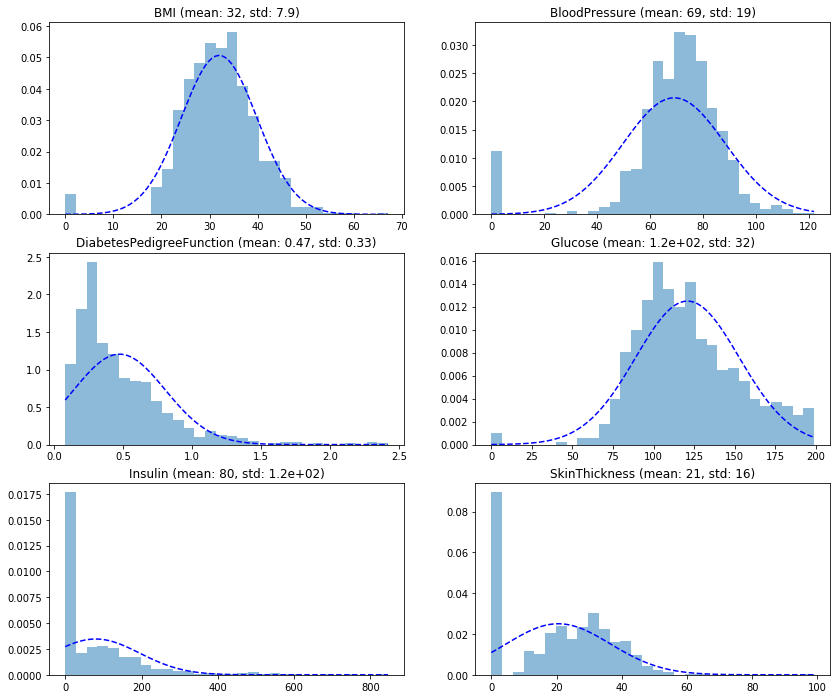

In [3]:
pm.plot_pima_features(pima);

## PIMA ML Models

In [4]:
models = pm.pima_models(x_train_p, y_train_p)

In [5]:
mlp = models['mlp']
rf = models['rf']
lr = models['lr']
ensemble = models['ensemble']

In [6]:
mlp_accuracy, mlp_precision, mlp_recall, mlp_f1, mlp_auc = mg.evaluate(mlp, x_validation_p, y_validation_p, False)
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc = mg.evaluate(rf, x_validation_p, y_validation_p, False)
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc = mg.evaluate(lr, x_validation_p, y_validation_p, False)
en_accuracy, en_precision, en_recall, en_f1, en_auc = mg.evaluate(ensemble, x_validation_p, y_validation_p, False)

## MAgECs

In [7]:
# MLP
case_mlp = mg.case_magecs(mlp, x_validation_p, model_name='mlp')
magecs_mlp = mg.normalize_magecs(case_mlp, features=None, model_name='mlp')
magecs_mlp = magecs_mlp.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# RF
case_rf = mg.case_magecs(rf, x_validation_p, model_name='rf')
magecs_rf = mg.normalize_magecs(case_rf, features=None, model_name='rf')
magecs_rf = magecs_rf.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# LR
case_lr = mg.case_magecs(lr, x_validation_p, model_name='lr')
magecs_lr = mg.normalize_magecs(case_lr, features=None, model_name='lr')
magecs_lr = magecs_lr.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# ENSEMBLE
case_en = mg.case_magecs(ensemble, x_validation_p, model_name='ensemble')
magecs_en = mg.normalize_magecs(case_en, features=None, model_name='ensemble')
magecs_en = magecs_en.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)

In [8]:
features = ['BloodPressure', 'BMI', 'Glucose', 'Insulin', 'SkinThickness']

In [9]:
joined = mg.magec_models(magecs_mlp, 
                         magecs_rf, 
                         magecs_lr, 
                         magecs_en,
                         Xdata=x_validation_p, 
                         Ydata=y_validation_p, 
                         features=features)

### MAgEC Rank-Biased-Overlap

In [10]:
weights_auc = {'mlp': mlp_auc, 'rf': rf_auc, 'lr': lr_auc}
weights_recall = {'mlp': mlp_recall, 'rf': rf_recall, 'lr': lr_recall}
models = ('mlp', 'rf', 'lr')
ranks = mg.magec_rank(joined, rank=len(features), features=features)
consensus_auc = mg.magec_consensus(ranks, use_weights=True, weights=weights_auc, models=models)
consensus_recall = mg.magec_consensus(ranks, use_weights=True, weights=weights_recall, models=models)
rbos = mg.magec_rbos(ranks, models=models)

### MAgEC Impact

Of the patients who were predicted by the panel of expert models (ensemble) to become a Type 2 Diabetic within the next 5 years, MAgEC identified at least one varible for each patient, which if controlled to the normal level within the patient's own population, are estimated to prevent the onset of the disease. 

In the case of this tiny Pima dataset, that is 49 out of 49

In [11]:
# joined['magec_positive'] = joined.apply(mg.magec_threshold, args=(features, 0.5, 'ensemble', models), axis=1)
# joined['magec_positive'].value_counts()

## Example Patient Cases

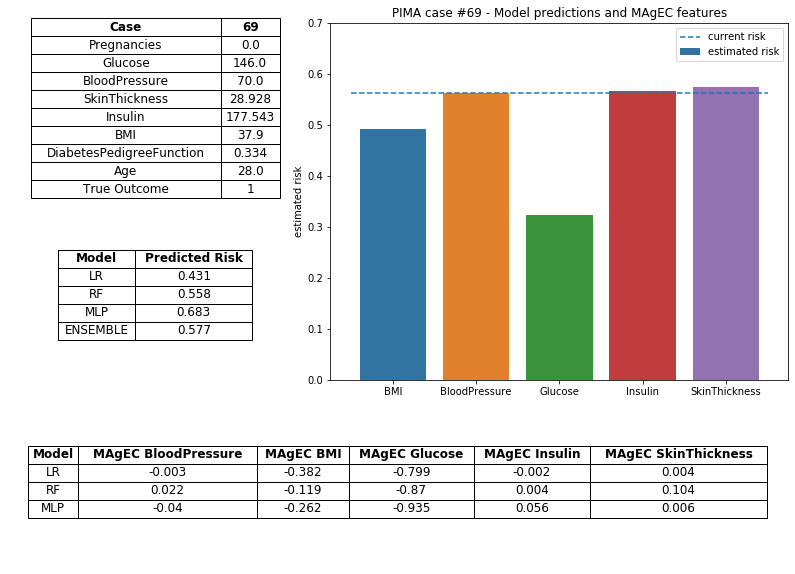

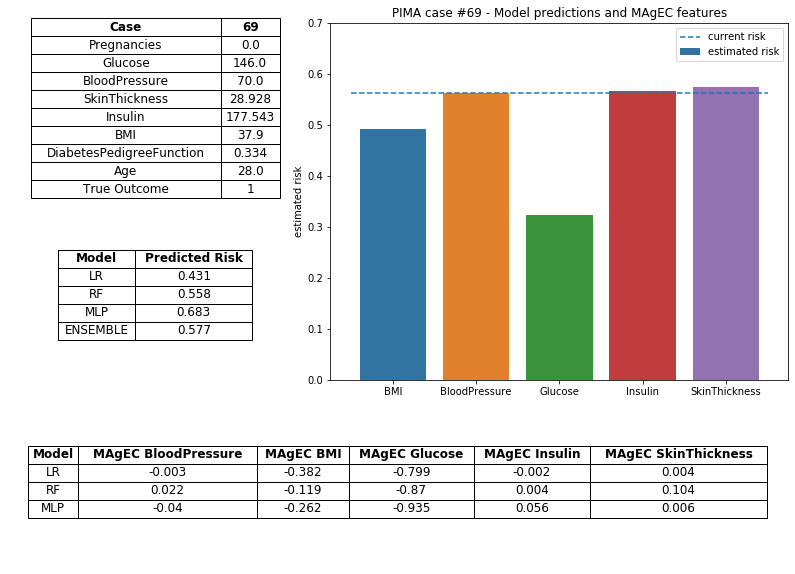

In [12]:
case = 69
mg.panel_plot(x_train.columns, features, stsc, joined, case, 
              models=('lr','rf','mlp','ensemble'), 
              title='PIMA case #69 - Model predictions and MAgEC features',
              save='pima_69')

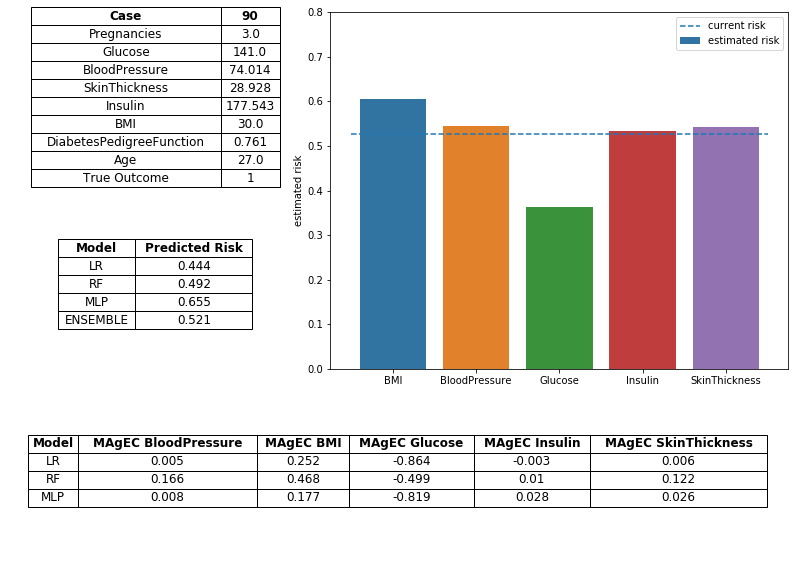

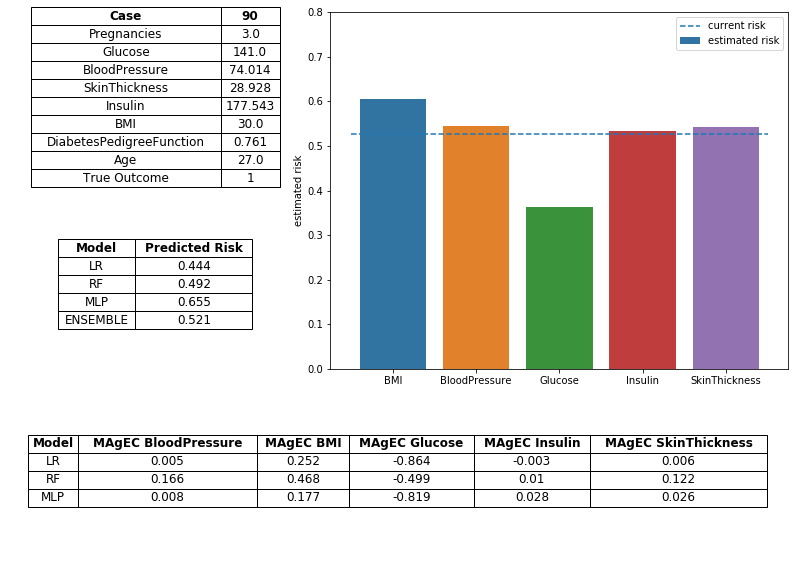

In [13]:
case = 90
mg.panel_plot(x_train.columns, features, stsc, joined, case, models=('lr','rf','mlp','ensemble'))

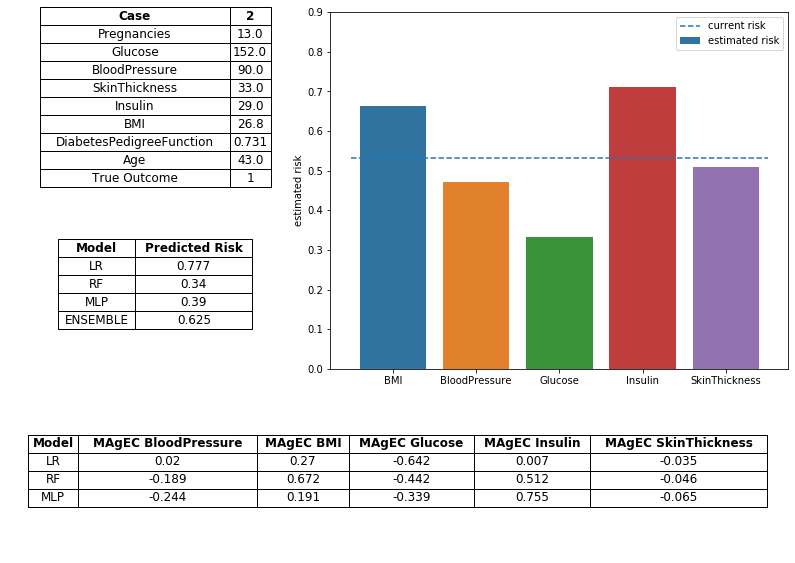

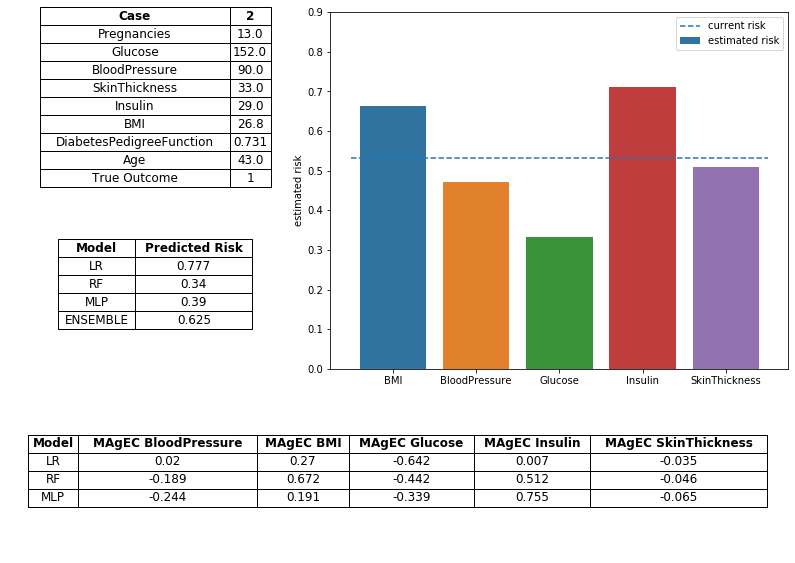

In [14]:
case = 2
mg.panel_plot(x_train.columns, features, stsc, joined, case, models=('lr','rf','mlp','ensemble'))

### RBOs Stats

In [15]:
rbos[['mlp_lr','rf_lr','rf_mlp']].mean()

mlp_lr    0.157402
rf_lr     0.107315
rf_mlp    0.098972
dtype: float64

In [16]:
rbos[['mlp_lr','rf_lr','rf_mlp']].std()

mlp_lr    0.140916
rf_lr     0.075735
rf_mlp    0.079214
dtype: float64

In [17]:
rbos99 = mg.magec_rbos(ranks, models=models, p=0.95)

In [18]:
rbos99[['mlp_lr','rf_lr','rf_mlp']].mean()

mlp_lr    0.091178
rf_lr     0.055417
rf_mlp    0.051127
dtype: float64

In [19]:
rbos99[['mlp_lr','rf_lr','rf_mlp']].std()

mlp_lr    0.134571
rf_lr     0.039608
rf_mlp    0.041223
dtype: float64

In [20]:
rbos1 = mg.magec_rbos(ranks, models=models, p=1)

In [21]:
rbos1[['mlp_lr','rf_lr','rf_mlp']].mean()

mlp_lr    0.753111
rf_lr     0.617379
rf_mlp    0.550325
dtype: float64

In [22]:
rbos1[['mlp_lr','rf_lr','rf_mlp']].std()

mlp_lr    0.313680
rf_lr     0.384726
rf_mlp    0.406777
dtype: float64